In [ ]:
!unzip data.zip

In [24]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
# ## 2. Data Loading and Preprocessing
try:
    # 수정된 데이터셋 경로
    base_path = '/content/tire-dataset'
    if not os.path.exists(base_path):
        raise FileNotFoundError

    # glob을 사용하여 모든 이미지 파일 경로를 가져옵니다.
    # 이미지 확장자가 .png가 아닐 경우, '*.jpg' 등으로 수정해주세요.
    image_paths = glob.glob(os.path.join(base_path, '*/*.png'))

    if not image_paths:
        print(f"Warning: No images found in '{base_path}'. Trying with .jpg extension...")
        image_paths = glob.glob(os.path.join(base_path, '*/*.jpg'))

    # 파일 경로에서 레이블을 추출합니다.
    labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

    df = pd.DataFrame({'path': image_paths, 'label': labels})

    # 레이블을 원-핫 인코딩으로 변환
    lb = LabelBinarizer()
    df['label_encoded'] = lb.fit_transform(df['label'].values).tolist()

    class_names = lb.classes_
    print(f"Dataset loaded successfully. Found {len(df)} images.")
    print(f"Class names found: {class_names}")

except FileNotFoundError:
    print(f"Error: Directory '{base_path}' not found. Please check the path.")
    df = pd.DataFrame()

Dataset loaded successfully. Found 900 images.
Class names found: ['flat.class' 'full.class' 'no-tire.class']


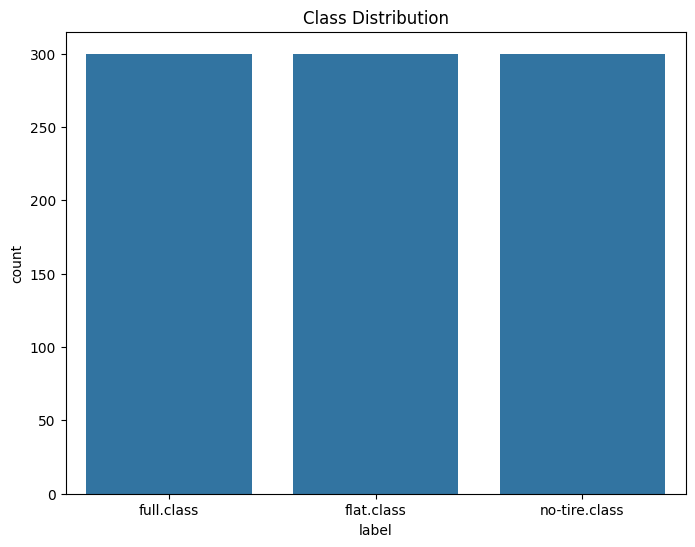

<Figure size 1000x500 with 0 Axes>

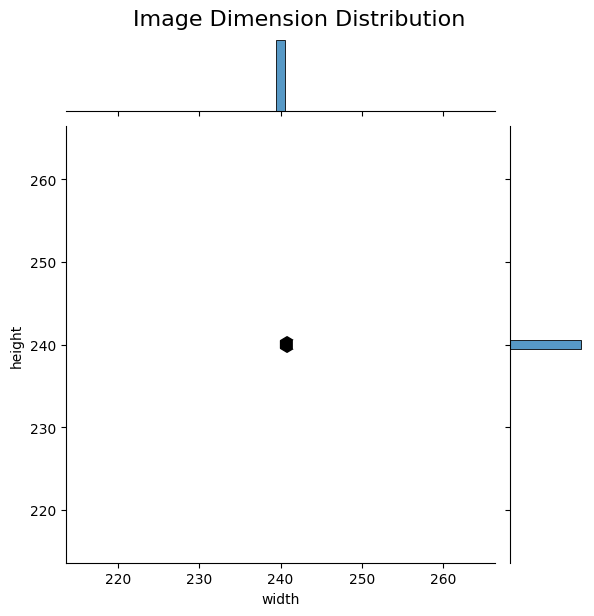

In [30]:
# ## 3. Exploratory Data Analysis (EDA)
# 클래스 분포 확인
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

# 이미지 크기 분포 분석
dimensions = []
for img_path in df['path']:
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            dimensions.append({'width': width, 'height': height})
    except:
        continue
dim_df = pd.DataFrame(dimensions)

plt.figure(figsize=(10, 5))
sns.jointplot(data=dim_df, x='width', y='height', kind='hex')
plt.suptitle('Image Dimension Distribution', y=1.02, fontsize=16)
plt.show()

In [31]:
# ## 4. Data Splitting and Augmentation
# 훈련, 검증, 테스트 데이터 분할
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42, stratify=train_val_df['label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator()

# 제너레이터 생성
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 100

# 이미지를 numpy 배열로 로드
def load_images(df_subset):
    images = []
    for path in df_subset['path']:
        img = tf.keras.preprocessing.image.load_img(path, target_size=IMAGE_SIZE)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        images.append(img)
    return np.array(images)

X_train = load_images(train_df)
y_train = np.array(train_df['label_encoded'].tolist())

X_val = load_images(val_df)
y_val = np.array(val_df['label_encoded'].tolist())

X_test = load_images(test_df)
y_test = np.array(test_df['label_encoded'].tolist())

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)


Training samples: 650
Validation samples: 115
Test samples: 135


In [32]:
# ## 5. Model Building (Transfer Learning with EfficientNetB0)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [33]:
# ## 6. Model Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 101s 11s/step - accuracy: 0.5707 - loss: 0.8520 - val_accuracy: 0.6783 - val_loss: 0.5082
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7273 - loss: 0.4748 - val_accuracy: 0.6696 - val_loss: 0.4858
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7925 - loss: 0.4127 - val_accuracy: 0.6609 - val_loss: 0.5525
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 988ms/step - accuracy: 0.7607 - loss: 0.4270 - val_accuracy: 0.6609 - val_loss: 0.5583
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8284 - loss: 0.3739 - val_accuracy: 0.7043 - val_loss: 0.4196
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7813 - loss: 0.3914 - val_accuracy: 0.7043 - val_loss: 0.4006
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8321 - loss: 0.3368 - val_accuracy: 0.9391 - val_loss: 0.2648
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8640 - loss: 0.3119 - val_accuracy: 0.9391 - val_loss: 0.2508
Epoch 9/3

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9881 - loss: 0.0761

Test Accuracy: 98.52%


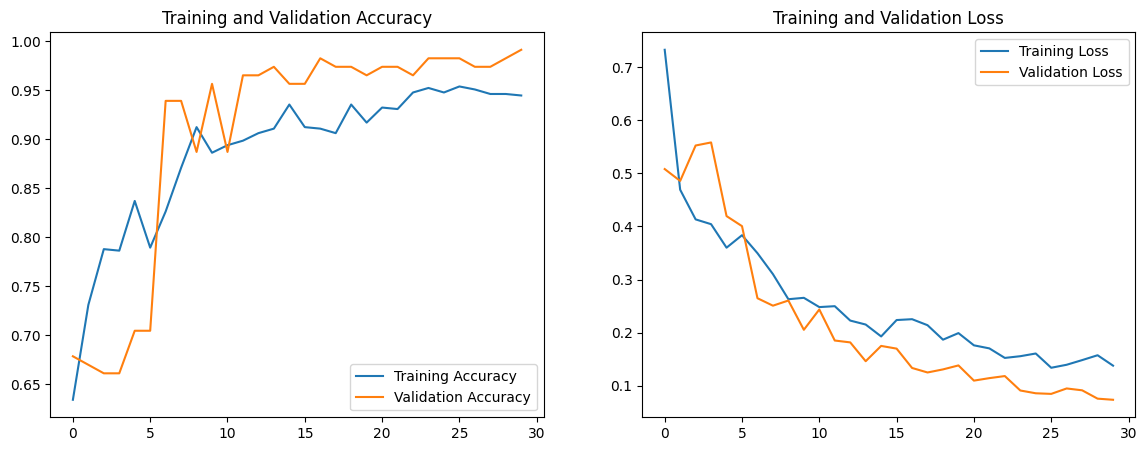

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [34]:
# ## 7. Performance Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'\nTest Accuracy: {accuracy*100:.2f}%')

# 학습 곡선 시각화
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 예측 및 평가
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

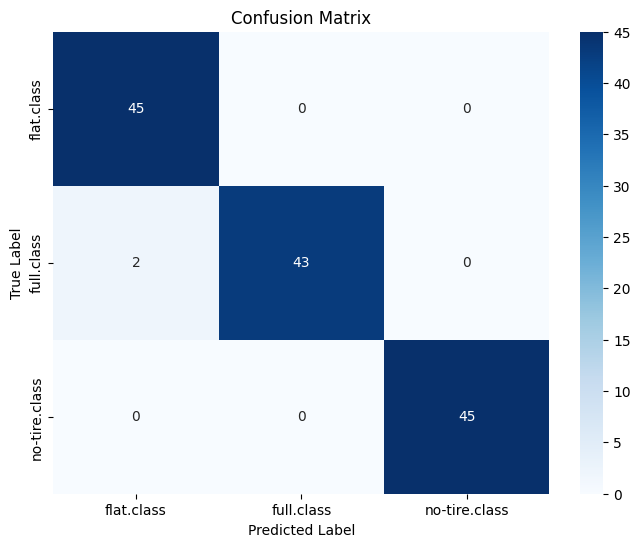


Classification Report
               precision    recall  f1-score   support

   flat.class       0.96      1.00      0.98        45
   full.class       1.00      0.96      0.98        45
no-tire.class       1.00      1.00      1.00        45

     accuracy                           0.99       135
    macro avg       0.99      0.99      0.99       135
 weighted avg       0.99      0.99      0.99       135


Total misclassified images: 2



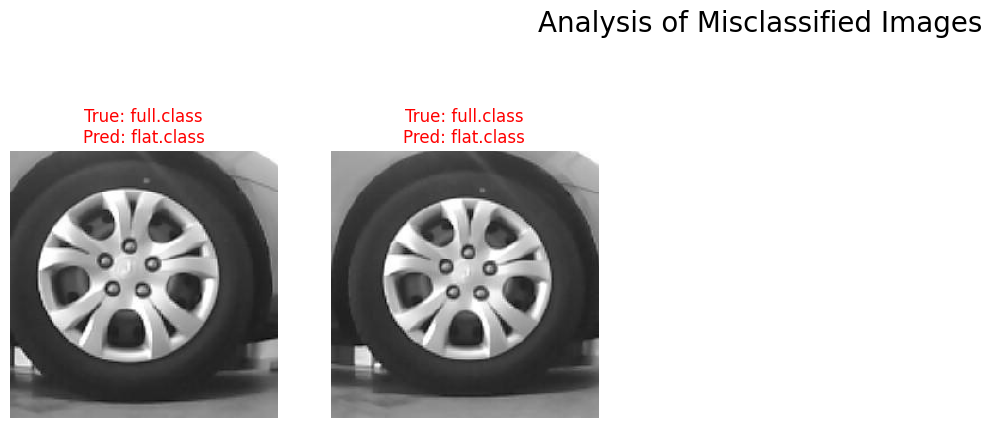

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print('\nClassification Report')
print(classification_report(y_true, y_pred, target_names=class_names))

# 오분류된 이미지 분석
misclassified_indices = np.where(y_pred != y_true)[0]
if len(misclassified_indices) > 0:
    print(f"\nTotal misclassified images: {len(misclassified_indices)}\n")
    plt.figure(figsize=(20, 10))
    random_indices = np.random.choice(misclassified_indices, size=min(10, len(misclassified_indices)), replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        img = X_test[idx]
        # 이미지를 표시하기 위해 정규화 역전환 (0~1 범위로)
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12, color='red')
        plt.axis('off')
    plt.suptitle('Analysis of Misclassified Images', fontsize=20)
    plt.show()